# Исследование и подготовка данных

1. Загрузка данных

In [76]:
import os
import pandas as pd

DATA_DIR = 'data'
DATA_EPI_R_PATH = f'{DATA_DIR}/epi_r.csv'

os.makedirs(DATA_DIR, exist_ok=True)

print(f"Загрузка данных из {DATA_EPI_R_PATH}...")
try:
    df = pd.read_csv(DATA_EPI_R_PATH)
except FileNotFoundError:
    print(f"Ошибка: Файл {DATA_EPI_R_PATH} не найден. Убедитесь, что он находится в той же директории, что и исследование.")
    raise

Загрузка данных из data/epi_r.csv...


2. Анализ данных

In [3]:
import seaborn as sns

# Настройки отображения Pandas и Seaborn
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")

# --- 1. Обзор данных ---
print("\n--- 1. ОБЗОР ДАННЫХ ---")
print("\nПервые 5 строк:")
print(df.head())


--- 1. ОБЗОР ДАННЫХ ---

Первые 5 строк:
                                         title  rating  calories  protein  \
0              Lentil, Apple, and Turkey Wrap    2.500     426.0     30.0   
1  Boudin Blanc Terrine with Red Onion Confit    4.375     403.0     18.0   
2                Potato and Fennel Soup Hodge    3.750     165.0      6.0   
3             Mahi-Mahi in Tomato Olive Sauce    5.000       NaN      NaN   
4                    Spinach Noodle Casserole    3.125     547.0     20.0   

    fat  sodium  #cakeweek  #wasteless  22-minute meals  3-ingredient recipes  \
0   7.0   559.0        0.0         0.0              0.0                   0.0   
1  23.0  1439.0        0.0         0.0              0.0                   0.0   
2   7.0   165.0        0.0         0.0              0.0                   0.0   
3   NaN     NaN        0.0         0.0              0.0                   0.0   
4  32.0   452.0        0.0         0.0              0.0                   0.0   

   30 da

In [4]:
print("\nТипы данных и информация о столбцах:")
df.info(verbose=True, show_counts=True) # verbose и show_counts дают больше деталей


Типы данных и информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Data columns (total 680 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    title                     20052 non-null  object 
 1    rating                    20052 non-null  float64
 2    calories                  15935 non-null  float64
 3    protein                   15890 non-null  float64
 4    fat                       15869 non-null  float64
 5    sodium                    15933 non-null  float64
 6    #cakeweek                 20052 non-null  float64
 7    #wasteless                20052 non-null  float64
 8    22-minute meals           20052 non-null  float64
 9    3-ingredient recipes      20052 non-null  float64
 10   30 days of groceries      20052 non-null  float64
 11   advance prep required     20052 non-null  float64
 12   alabama                   20052 non-null  float64
 13   alaska

In [5]:
# --- 2. Анализ целевой переменной (rating) ---
print("\n--- 2. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (rating) ---")
print("\nОписательная статистика для 'rating':")
print(df['rating'].describe())


--- 2. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (rating) ---

Описательная статистика для 'rating':
count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64


In [6]:
print("\nУникальные значения и их количество в 'rating':")
print(df['rating'].value_counts().sort_index())


Уникальные значения и их количество в 'rating':
rating
0.000    1836
1.250     164
1.875     124
2.500     532
3.125    1489
3.750    5169
4.375    8019
5.000    2719
Name: count, dtype: int64



Визуализация распределения 'rating':


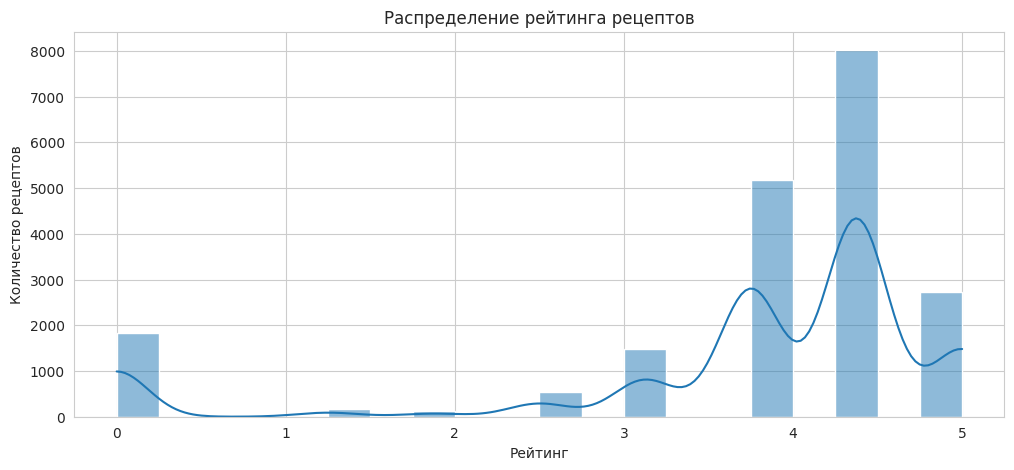

In [7]:
import matplotlib.pyplot as plt

print("\nВизуализация распределения 'rating':")
plt.figure(figsize=(12, 5))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Распределение рейтинга рецептов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество рецептов')
plt.show()

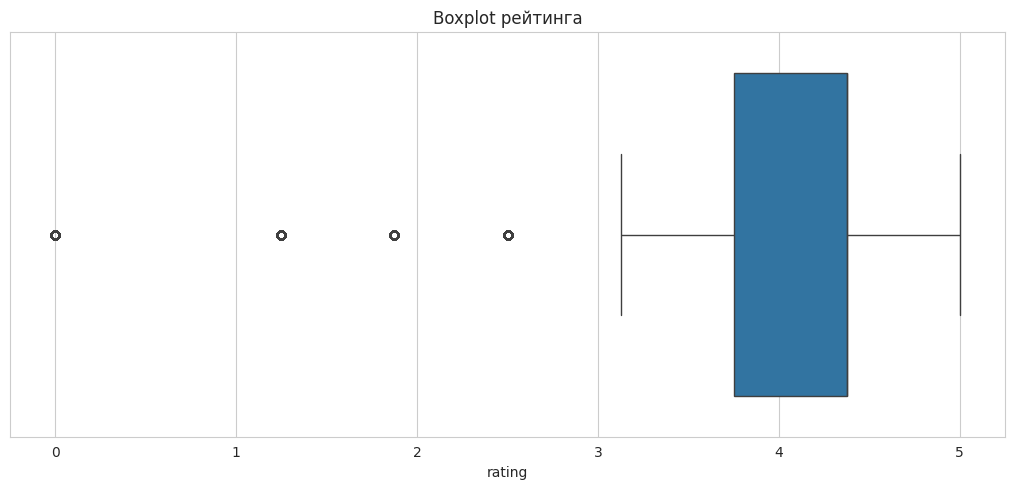

In [8]:
plt.figure(figsize=(10.25, 5))
sns.boxplot(x=df['rating'])
plt.title('Boxplot рейтинга')
plt.tight_layout()
plt.show()

In [9]:
rating_zero_count = (df['rating'] == 0).sum()
print(f"\nКоличество рецептов с рейтингом 0: {rating_zero_count} ({(rating_zero_count / len(df) * 100):.2f}%)")
# Возможно, рейтинг 0 означает "не оценено" или ошибку. Это требует внимания.


Количество рецептов с рейтингом 0: 1836 (9.16%)


In [77]:
# --- 3. Анализ признаков (Предполагаемые ингредиенты и другие столбцы) ---
print("\n--- 3. АНАЛИЗ ПРИЗНАКОВ ---")
all_columns = df.columns.tolist()
print(f"Всего столбцов: {len(all_columns)}")


--- 3. АНАЛИЗ ПРИЗНАКОВ ---
Всего столбцов: 680


In [78]:
# --- 4. Анализ пропусков ---
print("\n--- 4. АНАЛИЗ ПРОПУСКОВ ---")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({'count': missing_values, 'percent': missing_percent})
missing_summary = missing_summary[missing_summary['count'] > 0].sort_values('percent', ascending=False)

print("\nСтолбцы с пропущенными значениями:")
if missing_summary.empty:
    print("Пропущенных значений не найдено.")
else:
    print(missing_summary)


--- 4. АНАЛИЗ ПРОПУСКОВ ---

Столбцы с пропущенными значениями:
          count    percent
fat        4183  20.860762
protein    4162  20.756034
sodium     4119  20.541592
calories   4117  20.531618


In [79]:
# --- 5. Анализ дубликатов ---
print("\n--- 5. АНАЛИЗ ДУБЛИКАТОВ ---")
total_duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов строк: {total_duplicates}")

# Часто дубликаты могут быть по названию рецепта
title_duplicates = df.duplicated(subset=['title']).sum()
print(f"Количество дубликатов по столбцу 'title': {title_duplicates}")
if title_duplicates > 0:
    print("Пример дублирующихся названий:")
    print(df[df.duplicated(subset=['title'], keep=False)].sort_values('title').head())



--- 5. АНАЛИЗ ДУБЛИКАТОВ ---
Количество полных дубликатов строк: 1801
Количество дубликатов по столбцу 'title': 2316
Пример дублирующихся названий:
                                             title  rating  calories  protein  \
17331                           4-3-2-1 Spice Rub    4.375      16.0      0.0   
20032                           4-3-2-1 Spice Rub    4.375      16.0      0.0   
5352   Acini di Pepe Pasta with Garlic and Olives    4.375     209.0      5.0   
96     Acini di Pepe Pasta with Garlic and Olives    4.375     209.0      5.0   
16147             Adobo-Glazed Mini Turkey Loaves    4.375       NaN      NaN   

       fat  sodium  #cakeweek  #wasteless  22-minute meals  \
17331  0.0  2292.0        0.0         0.0              0.0   
20032  0.0  2292.0        0.0         0.0              0.0   
5352   8.0    77.0        0.0         0.0              0.0   
96     8.0    77.0        0.0         0.0              0.0   
16147  NaN     NaN        0.0         0.0             

2. Обработка данных

In [80]:
print(f"Размер до удаления полных дубликатов: {df.shape}")
df = df.drop_duplicates()
print(f"Размер после удаления полных дубликатов: {df.shape}")

Размер до удаления полных дубликатов: (20052, 680)
Размер после удаления полных дубликатов: (18251, 680)


In [81]:
print(f"Размер до удаления дубликатов по title: {df.shape}")
df = df.drop_duplicates(subset=['title'], keep='first')
print(f"Размер после удаления дубликатов по title: {df.shape}")

Размер до удаления дубликатов по title: (18251, 680)
Размер после удаления дубликатов по title: (17736, 680)


In [82]:
print(f"Размер до удаления рейтинга 0: {df.shape}")
df = df[df['rating'] > 0].copy()
print(f"Размер после удаления рейтинга 0: {df.shape}")
print("\nПроверка оставшихся значений рейтинга:")
print(df['rating'].value_counts().sort_index())

Размер до удаления рейтинга 0: (17736, 680)
Размер после удаления рейтинга 0: (16168, 680)

Проверка оставшихся значений рейтинга:
rating
1.250     139
1.875     104
2.500     473
3.125    1323
3.750    4645
4.375    7180
5.000    2304
Name: count, dtype: int64


Практика воспользоваться предложенным API в контексте задания, привела к большому колличеству неверных ответов для определения что является, а что нет индигриентом. Поэтому список подготовлен в ручную.

In [83]:
import json

INGRIDIENTS_FILE = f'{DATA_DIR}/ingredients.json'

def ingridients():
  try:
    with open(INGRIDIENTS_FILE, 'r') as f:
      result = []
      data = json.load(f)
      for key, value in data.items():
        if value:
          result.append(key)
      return result
  except FileNotFoundError:
    return {}
  
ingridients_list = ingridients()
  
print(f"Размер до отсева по ингридиетам: {df.shape}")
df = df[['title', 'rating'] + ingridients_list]
print(f"Размер после отсева по ингридиетам: {df.shape}")

Размер до отсева по ингридиетам: (16168, 680)
Размер после отсева по ингридиетам: (16168, 344)


3. Прогнозирование - Регрессия (Анализ числового рейтинга)

In [17]:
# 1. Определение признаков (X) и целевой переменной (y)
X = df[ingridients_list]
y = df['rating']

print(f"\nОпределение признаков (X), размерность: {X.shape}")
print(f"Определение цели (y), размерность: {y.shape}")


Определение признаков (X), размерность: (16168, 342)
Определение цели (y), размерность: (16168,)


In [18]:
from sklearn.model_selection import train_test_split

# Константа для воспроизводимости
RANDOM_STATE = 42
TEST_SIZE = 0.25

stratify_raiting = y.apply(lambda r: 'bad' if r < 2 else ('so-so' if r < 4 else 'great'))
print("\nРаспределение категорий для стратификации:")
print(stratify_raiting.value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=stratify_raiting
)

# Проверка размеров полученных выборок
print("\nРазмеры выборок:")
print(f"  Обучающая выборка X_train: {X_train.shape}")
print(f"  Тестовая выборка X_test:  {X_test.shape}")
print(f"  Обучающая выборка y_train: {y_train.shape}")
print(f"  Тестовая выборка y_test:  {y_test.shape}")

# Проверим распределение целевой переменной в train и test (среднее)
print("\nСредний рейтинг:")
print(f"  В обучающей выборке (y_train): {y_train.mean():.4f}")
print(f"  В тестовой выборке (y_test):  {y_test.mean():.4f}")
print(f"  В исходной выборке (y):      {y.mean():.4f}")


Распределение категорий для стратификации:
rating
great    0.586591
so-so    0.398380
bad      0.015030
Name: proportion, dtype: float64

Размеры выборок:
  Обучающая выборка X_train: (12126, 342)
  Тестовая выборка X_test:  (4042, 342)
  Обучающая выборка y_train: (12126,)
  Тестовая выборка y_test:  (4042,)

Средний рейтинг:
  В обучающей выборке (y_train): 4.0837
  В тестовой выборке (y_test):  4.0865
  В исходной выборке (y):      4.0844


### Метрики оценки регрессии:

Как понять, насколько хорошо работает регрессионная модель? Нам нужны метрики, которые измеряют "расстояние" или "ошибку" между истинными значениями (y_test) и предсказанными моделью (y_pred).

1. RMSE (Root Mean Squared Error / Корень из среднеквадратичной ошибки):
  * Что это: Корень из среднего значения квадратов разностей между предсказанными и истинными значениями.
  * Формула: sqrt(mean((y_true - y_pred)^2))
  * Интерпретация: Показывает "типичное" или "среднеквадратичное" отклонение предсказаний от реальных значений. Измеряется в тех же единицах, что и целевая переменная (в нашем случае — в баллах рейтинга). Сильно штрафует за большие ошибки (из-за возведения в квадрат). Чем ниже RMSE, тем лучше. Это основная метрика, указанная в задании.
  * В Scikit-learn: mean_squared_error(y_true, y_pred, squared=False)
2. MAE (Mean Absolute Error / Средняя абсолютная ошибка):
  * Что это: Среднее значение абсолютных разностей между предсказанными и истинными значениями.
  * Формула: mean(|y_true - y_pred|)
  * Интерпретация: Показывает "среднее" абсолютное отклонение предсказаний. Также измеряется в единицах целевой переменной. Менее чувствительна к выбросам, чем RMSE. Чем ниже MAE, тем лучше. Хорошо использовать в дополнение к RMSE.
  * В Scikit-learn: mean_absolute_error(y_true, y_pred)
3. R² (R-squared / Коэффициент детерминации):
  * Что это: Доля дисперсии (вариативности) целевой переменной, которая объясняется моделью.
  * Интерпретация: Показывает, насколько хорошо модель "подходит" к данным по сравнению с простой моделью, предсказывающей среднее значение.
    * R² = 1: Идеальная модель, объясняет всю вариативность.
    * R² = 0: Модель работает не лучше, чем простое предсказание среднего (именно такой результат мы ожидаем от DummyRegressor(strategy='mean')).
    * R² < 0: Модель работает хуже, чем предсказание среднего.
  * Чем ближе R² к 1, тем лучше.
  * В Scikit-learn: r2_score(y_true, y_pred) или метод .score() у обученной модели регрессии.


In [19]:
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("--- Оценка DummyRegressor (Baseline) ---")

# 1. Стратегия: Предсказание среднего значения y_train
print("\n1. Стратегия: предсказание среднего")
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(X_train, y_train) # Модель запоминает среднее y_train, X_train игнорируется
y_pred_dummy_mean = dummy_mean.predict(X_test) # Предсказывает одно и то же среднее для всех в X_test

# Оценка DummyRegressor (mean)
rmse_dummy_mean = np.sqrt(mean_squared_error(y_test, y_pred_dummy_mean))
mae_dummy_mean = mean_absolute_error(y_test, y_pred_dummy_mean)
r2_dummy_mean = r2_score(y_test, y_pred_dummy_mean) # Ожидаем значение около 0

print(f"   Предсказанное значение (среднее y_train): {y_pred_dummy_mean[0]:.4f}") # Все предсказания одинаковы
print(f"   RMSE: {rmse_dummy_mean:.4f}")
print(f"   MAE:  {mae_dummy_mean:.4f}")
print(f"   R²:   {r2_dummy_mean:.4f}")

# 2. Стратегия: Предсказание медианы y_train
print("\n2. Стратегия: предсказание медианы")
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(X_train, y_train) # Модель запоминает медиану y_train
y_pred_dummy_median = dummy_median.predict(X_test) # Предсказывает медиану для всех

# Оценка DummyRegressor (median)
rmse_dummy_median = np.sqrt(mean_squared_error(y_test, y_pred_dummy_median))
mae_dummy_median = mean_absolute_error(y_test, y_pred_dummy_median)
r2_dummy_median = r2_score(y_test, y_pred_dummy_median) # Может отличаться от 0, если среднее и медиана не совпадают

print(f"   Предсказанное значение (медиана y_train): {y_pred_dummy_median[0]:.4f}")
print(f"   RMSE: {rmse_dummy_median:.4f}")
print(f"   MAE:  {mae_dummy_median:.4f}")
print(f"   R²:   {r2_dummy_median:.4f}")

print("\n--- Базовые метрики установлены ---")
print(f"Любая полезная регрессионная модель должна иметь RMSE < {min(rmse_dummy_mean, rmse_dummy_median):.4f}")
print(f"и R² > {max(r2_dummy_mean, r2_dummy_median):.4f}")

--- Оценка DummyRegressor (Baseline) ---

1. Стратегия: предсказание среднего
   Предсказанное значение (среднее y_train): 4.0837
   RMSE: 0.6659
   MAE:  0.5211
   R²:   -0.0000

2. Стратегия: предсказание медианы
   Предсказанное значение (медиана y_train): 4.3750
   RMSE: 0.7257
   MAE:  0.4707
   R²:   -0.1877

--- Базовые метрики установлены ---
Любая полезная регрессионная модель должна иметь RMSE < 0.6659
и R² > -0.0000


Проработка инных методов с целью сравнения с базовой моделью

In [20]:
import time

# --- Импорт моделей ---
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# --- Также нужны baseline метрики ---
baseline_rmse = min(rmse_dummy_mean, rmse_dummy_median)
baseline_r2 = max(r2_dummy_mean, r2_dummy_median)

# --- Словарь для хранения результатов ---
results = {}

# --- Список моделей для тестирования ---
# Добавляем 'alpha=1.0' для регуляризованных моделей, чтобы избежать предупреждений
# Увеличиваем max_iter для Lasso/ElasticNet, чтобы улучшить сходимость
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "Lasso": Lasso(alpha=0.001, max_iter=5000, random_state=RANDOM_STATE), # Маленькая alpha для начала
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=5000, random_state=RANDOM_STATE), # Маленькая alpha
    "Decision Tree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1), # n_jobs=-1 использует все ядра CPU
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE),
    "KNN": KNeighborsRegressor(n_neighbors=5, n_jobs=-1), # n_jobs=-1 ускорит поиск соседей
    "SVR": SVR(kernel='rbf') # SVR может быть ОЧЕНЬ медленным на больших данных
}

# --- Цикл обучения и оценки ---
for name, model in models.items():
    print(f"--- Обучение и оценка: {name} ---")
    start_time = time.time()

    # Обучение
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Предсказание
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time

    # Оценка
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Сохранение результатов
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Train Time (s)': train_time, 'Predict Time (s)': predict_time}

    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  Время обучения: {train_time:.2f} сек")
    print(f"  Время предсказания: {predict_time:.2f} сек")
    # Сравнение с baseline (если baseline_rmse и baseline_r2 определены)
    try:
        if rmse < baseline_rmse:
            print(f"  Результат: ЛУЧШЕ baseline по RMSE ({rmse:.4f} < {baseline_rmse:.4f})")
        else:
            print(f"  Результат: ХУЖЕ baseline по RMSE ({rmse:.4f} >= {baseline_rmse:.4f})")
        if r2 > baseline_r2:
             print(f"  Результат: ЛУЧШЕ baseline по R² ({r2:.4f} > {baseline_r2:.4f})")
        else:
             print(f"  Результат: ХУЖЕ baseline по R² ({r2:.4f} <= {baseline_r2:.4f})")
    except NameError:
        print("  (Baseline метрики не определены для сравнения)")
    print("-" * 30)

# --- Вывод итоговой таблицы результатов ---
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='RMSE', ascending=True)

print("\n--- Сводная таблица результатов (на тестовой выборке) ---")
print(results_df)

--- Обучение и оценка: Linear Regression ---
  RMSE: 0.6674
  MAE:  0.5023
  R²:   -0.0043
  Время обучения: 2.16 сек
  Время предсказания: 0.05 сек
  Результат: ХУЖЕ baseline по RMSE (0.6674 >= 0.6659)
  Результат: ХУЖЕ baseline по R² (-0.0043 <= -0.0000)
------------------------------
--- Обучение и оценка: Ridge ---
  RMSE: 0.6636
  MAE:  0.5009
  R²:   0.0070
  Время обучения: 0.09 сек
  Время предсказания: 0.00 сек
  Результат: ЛУЧШЕ baseline по RMSE (0.6636 < 0.6659)
  Результат: ЛУЧШЕ baseline по R² (0.0070 > -0.0000)
------------------------------
--- Обучение и оценка: Lasso ---
  RMSE: 0.6595
  MAE:  0.5091
  R²:   0.0191
  Время обучения: 6.16 сек
  Время предсказания: 0.01 сек
  Результат: ЛУЧШЕ baseline по RMSE (0.6595 < 0.6659)
  Результат: ЛУЧШЕ baseline по R² (0.0191 > -0.0000)
------------------------------
--- Обучение и оценка: ElasticNet ---
  RMSE: 0.6582
  MAE:  0.5042
  R²:   0.0231
  Время обучения: 20.59 сек
  Время предсказания: 0.01 сек
  Результат: ЛУЧШЕ bas

Если проанализировать модели которые мы запустили на дефолтных значения. Мы заметим, что приоритетные модели для дальнейшей обработки ElasticNet, Lasso, Gradient Boosting.

In [21]:
from sklearn.model_selection import cross_val_score

print("--- Кросс-валидация для топ-4 моделей (на обучающей выборке) ---")

# --- Модели для кросс-валидации ---
models_for_cv = dict(filter(lambda item: item[0] in results_df.index[:4].tolist(), models.items()))

# --- Словарь для хранения результатов CV ---
cv_results = {}

# --- Параметры CV ---
cv_folds = 5 # 5-кратная кросс-валидация
scoring_metric = 'neg_mean_squared_error'

# --- Цикл кросс-валидации ---
for name, model in models_for_cv.items():
    print(f"\nЗапуск CV для: {name}")
    start_time = time.time()

    # Выполнение кросс-валидации
    # cross_val_score возвращает массив оценок (отрицательный MSE для каждого фолда)
    neg_mse_scores = cross_val_score(model, X_train, y_train,
                                     scoring=scoring_metric,
                                     cv=cv_folds,
                                     n_jobs=-1) # Используем все ядра CPU

    # Преобразование отрицательного MSE в RMSE
    rmse_scores = np.sqrt(-neg_mse_scores)

    cv_time = time.time() - start_time

    # Расчет среднего и стандартного отклонения RMSE
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)

    # Сохранение результатов
    cv_results[name] = {'Mean RMSE': mean_rmse, 'Std RMSE': std_rmse, 'CV Time (s)': cv_time}

    print(f"  Завершено за: {cv_time:.2f} сек")
    print(f"  RMSE по фолдам: {np.round(rmse_scores, 4)}")
    print(f"  Средний RMSE: {mean_rmse:.4f}")
    print(f"  Стандартное отклонение RMSE: {std_rmse:.4f}")
    print("-" * 30)

# --- Вывод итоговой таблицы результатов CV ---
cv_results_df = pd.DataFrame(cv_results).T
cv_results_df = cv_results_df.sort_values(by='Mean RMSE', ascending=True)

print("\n--- Сводная таблица результатов кросс-валидации (на обучающей выборке) ---")
print(cv_results_df)

--- Кросс-валидация для топ-4 моделей (на обучающей выборке) ---

Запуск CV для: Ridge
  Завершено за: 1.42 сек
  RMSE по фолдам: [0.654  0.6519 0.6725 0.6525 0.6588]
  Средний RMSE: 0.6579
  Стандартное отклонение RMSE: 0.0077
------------------------------

Запуск CV для: Lasso
  Завершено за: 0.91 сек
  RMSE по фолдам: [0.647  0.6457 0.6661 0.6531 0.6606]
  Средний RMSE: 0.6545
  Стандартное отклонение RMSE: 0.0078
------------------------------

Запуск CV для: ElasticNet
  Завершено за: 0.98 сек
  RMSE по фолдам: [0.6467 0.6448 0.6661 0.6514 0.6581]
  Средний RMSE: 0.6534
  Стандартное отклонение RMSE: 0.0078
------------------------------

Запуск CV для: Gradient Boosting
  Завершено за: 2.82 сек
  RMSE по фолдам: [0.6476 0.6457 0.6678 0.6547 0.6613]
  Средний RMSE: 0.6554
  Стандартное отклонение RMSE: 0.0083
------------------------------

--- Сводная таблица результатов кросс-валидации (на обучающей выборке) ---
                   Mean RMSE  Std RMSE  CV Time (s)
ElasticNet    

In [22]:
from sklearn.model_selection import GridSearchCV

print("--- Подбор гиперпараметров для ElasticNet с помощью GridSearchCV ---")

# Определяем сетку параметров для ElasticNet
param_grid_elastic = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0], # Разные порядки силы регуляризации
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0] # Разный баланс L1/L2 (1.0 = Lasso)
    # 'max_iter': [5000] # Можно оставить значение по умолчанию или увеличить, если не сходится
}

# Инициализируем GridSearchCV
# n_jobs=-1 использует все ядра, verbose=2 показывает прогресс
grid_search_elastic = GridSearchCV(
    estimator=ElasticNet(random_state=RANDOM_STATE, max_iter=5000), # Увеличим max_iter на всякий случай
    param_grid=param_grid_elastic,
    scoring='neg_mean_squared_error', # Ищем минимум RMSE (максимум -RMSE)
    cv=5, # 5-кратная кросс-валидация
    n_jobs=-1,
    verbose=2
)

# Запускаем поиск
start_time = time.time()
print("Запуск GridSearchCV для ElasticNet...")
grid_search_elastic.fit(X_train, y_train)
search_time = time.time() - start_time
print(f"Поиск для ElasticNet завершен за: {search_time:.2f} сек")

# Выводим лучшие результаты
print(f"\nЛучшие параметры для ElasticNet: {grid_search_elastic.best_params_}")
best_rmse_elastic_cv = np.sqrt(-grid_search_elastic.best_score_)
print(f"Лучший средний RMSE по CV для ElasticNet: {best_rmse_elastic_cv:.4f}")

# Сохраняем лучшую модель
best_elastic_model = grid_search_elastic.best_estimator_

--- Подбор гиперпараметров для ElasticNet с помощью GridSearchCV ---
Запуск GridSearchCV для ElasticNet...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .........................alpha=0.0001, l1_ratio=0.3; total time=   0.1s
[CV] END .........................alpha=0.0001, l1_ratio=0.3; total time=   0.1s
[CV] END .........................alpha=0.0001, l1_ratio=0.5; total time=   0.1s
[CV] END .........................alpha=0.0001, l1_ratio=0.1; total time=   0.1s
[CV] END .........................alpha=0.0001, l1_ratio=0.3; total time=   0.1s
[CV] END .........................alpha=0.0001, l1_ratio=0.5; total time=   0.1s
[CV] END .........................alpha=0.0001, l1_ratio=0.7; total time=   0.1s
[CV] END .........................alpha=0.0001, l1_ratio=0.7; total time=   0.1s
[CV] END .........................alpha=0.0001, l1_ratio=0.5; total time=   0.1s
[CV] END .........................alpha=0.0001, l1_ratio=0.3; total time=   0.2s
[CV] END ............

In [23]:
print("\n--- Подбор гиперпараметров для Gradient Boosting с помощью GridSearchCV ---")

# Определяем сетку параметров для GradientBoostingRegressor
# Сетка может быть большой, начнем с умеренного варианта
param_grid_gb = {
    'n_estimators': [100, 200, 300], # Количество деревьев
    'learning_rate': [0.05, 0.1],   # Темп обучения
    'max_depth': [3, 5],             # Максимальная глубина
    'min_samples_leaf': [1, 3],        # Мин. образцов в листе
    'subsample': [0.8, 1.0]         # Можно добавить стохастичности
}

# Инициализируем GridSearchCV
grid_search_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gb,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Запускаем поиск
start_time = time.time()
print("Запуск GridSearchCV для Gradient Boosting...")
grid_search_gb.fit(X_train, y_train)
search_time = time.time() - start_time
print(f"Поиск для Gradient Boosting завершен за: {search_time:.2f} сек")

# Выводим лучшие результаты
print(f"\nЛучшие параметры для Gradient Boosting: {grid_search_gb.best_params_}")
best_rmse_gb_cv = np.sqrt(-grid_search_gb.best_score_)
print(f"Лучший средний RMSE по CV для Gradient Boosting: {best_rmse_gb_cv:.4f}")

# Сохраняем лучшую модель
best_gb_model = grid_search_gb.best_estimator_


--- Подбор гиперпараметров для Gradient Boosting с помощью GridSearchCV ---
Запуск GridSearchCV для Gradient Boosting...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time=   2.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, n_estimators=100, subsample=1.0; total time=   2.5s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, n_estimators=100, subsample=1.0; total time=   2.5s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time=   2.7s
[CV] END learning_

In [24]:
print("\n--- Подбор гиперпараметров завершен ---")

# --- Сравнение лучших результатов CV ---
print("\nСравнение лучших моделей по среднему RMSE на кросс-валидации:")
print(f"  ElasticNet: {best_rmse_elastic_cv:.4f}")
print(f"  Gradient Boosting: {best_rmse_gb_cv:.4f}")

# Выбираем финальную лучшую модель
if best_rmse_elastic_cv < best_rmse_gb_cv:
    final_best_model = best_elastic_model
    final_best_model_name = "ElasticNet"
    final_best_cv_rmse = best_rmse_elastic_cv
    print(f"\nФинальная лучшая модель по CV: ElasticNet с RMSE={final_best_cv_rmse:.4f}")
else:
    final_best_model = best_gb_model
    final_best_model_name = "Gradient Boosting"
    final_best_cv_rmse = best_rmse_gb_cv
    print(f"\nФинальная лучшая модель по CV: Gradient Boosting с RMSE={final_best_cv_rmse:.4f}")

# --- Финальная оценка лучшей модели на тестовой выборке ---
print(f"\n--- Финальная оценка модели '{final_best_model_name}' на тестовой выборке (X_test, y_test) ---")
y_pred_final = final_best_model.predict(X_test)

final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_mae = mean_absolute_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)

print(f"  Итоговый RMSE на тесте: {final_rmse:.4f}")
print(f"  Итоговый MAE на тесте:  {final_mae:.4f}")
print(f"  Итоговый R² на тесте:   {final_r2:.4f}")

# Не забудьте сравнить final_rmse с baseline_rmse!
try:
    if final_rmse < baseline_rmse:
        print(f"\nУспех! Итоговый RMSE ({final_rmse:.4f}) лучше baseline ({baseline_rmse:.4f}).")
    else:
        print(f"\nВнимание! Итоговый RMSE ({final_rmse:.4f}) не лучше baseline ({baseline_rmse:.4f}).")
except NameError:
    print("\n(Baseline RMSE не определен для сравнения)")


--- Подбор гиперпараметров завершен ---

Сравнение лучших моделей по среднему RMSE на кросс-валидации:
  ElasticNet: 0.6535
  Gradient Boosting: 0.6546

Финальная лучшая модель по CV: ElasticNet с RMSE=0.6535

--- Финальная оценка модели 'ElasticNet' на тестовой выборке (X_test, y_test) ---
  Итоговый RMSE на тесте: 0.6582
  Итоговый MAE на тесте:  0.5042
  Итоговый R² на тесте:   0.0231

Успех! Итоговый RMSE (0.6582) лучше baseline (0.6659).


4. Прогнозирование - Классификация (Анализ классов рейтинга)

In [27]:
def categorize_rating(rating):
    if rating < 2:
        return 'bad'
    elif rating < 4:
        return 'so-so'
    else: # rating >= 4
        return 'great'

y_train_cat = y_train.apply(categorize_rating)
y_test_cat = y_test.apply(categorize_rating)

print("\nРаспределение категорий 'bad'/'so-so'/'great' (Train):")
print(y_train_cat.value_counts(normalize=True))
print("\nРаспределение категорий 'bad'/'so-so'/'great' (Test):")
print(y_test_cat.value_counts(normalize=True))
# Теперь y_train_cat и y_test_cat - ваши целевые для этой задачи


Распределение категорий 'bad'/'so-so'/'great' (Train):
rating
great    0.586591
so-so    0.398400
bad      0.015009
Name: proportion, dtype: float64

Распределение категорий 'bad'/'so-so'/'great' (Test):
rating
great    0.586591
so-so    0.398318
bad      0.015092
Name: proportion, dtype: float64


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- Используем y_train_cat и y_test_cat ---

print("\n--- Baseline для Классификации ('bad'/'so-so'/'great') ---")
# Стратегия: самый частый класс
dummy_clf_mf = DummyClassifier(strategy="most_frequent")
dummy_clf_mf.fit(X_train, y_train_cat)
y_pred_dummy_mf = dummy_clf_mf.predict(X_test)
accuracy_dummy_mf = accuracy_score(y_test_cat, y_pred_dummy_mf)
print(f"\nDummy Classifier (most_frequent):")
print(f"  Accuracy: {accuracy_dummy_mf:.4f}") # Эта accuracy будет равна доле самого частого класса
print(f"  Предсказанный класс: {y_pred_dummy_mf[0]}")
print(classification_report(y_test_cat, y_pred_dummy_mf, zero_division=0))


--- Baseline для Классификации ('bad'/'so-so'/'great') ---

Dummy Classifier (most_frequent):
  Accuracy: 0.5866
  Предсказанный класс: great
              precision    recall  f1-score   support

         bad       0.00      0.00      0.00        61
       great       0.59      1.00      0.74      2371
       so-so       0.00      0.00      0.00      1610

    accuracy                           0.59      4042
   macro avg       0.20      0.33      0.25      4042
weighted avg       0.34      0.59      0.43      4042



In [29]:
# Опционально: другие стратегии для сравнения
dummy_clf_strat = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
dummy_clf_strat.fit(X_train, y_train_cat)
y_pred_dummy_strat = dummy_clf_strat.predict(X_test)
accuracy_dummy_strat = accuracy_score(y_test_cat, y_pred_dummy_strat)
print(f"\nDummy Classifier (stratified):")
print(f"  Accuracy: {accuracy_dummy_strat:.4f}")
print(classification_report(y_test_cat, y_pred_dummy_strat, zero_division=0))


Dummy Classifier (stratified):
  Accuracy: 0.5064
              precision    recall  f1-score   support

         bad       0.02      0.02      0.02        61
       great       0.59      0.59      0.59      2371
       so-so       0.40      0.40      0.40      1610

    accuracy                           0.51      4042
   macro avg       0.34      0.34      0.34      4042
weighted avg       0.50      0.51      0.51      4042



In [30]:
baseline_accuracy = accuracy_dummy_mf # Запоминаем accuracy самого частого класса
print(f"\nBaseline Accuracy (most frequent): {baseline_accuracy:.4f}")


Baseline Accuracy (most frequent): 0.5866


In [33]:
from sklearn.metrics import f1_score, confusion_matrix

# --- Импорт моделей ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

# --- Также нужны baseline метрики ---
baseline_accuracy = baseline_accuracy
baseline_f1_weighted = f1_score(y_test_cat, y_pred_dummy_mf, average='weighted', zero_division=0)
baseline_f1_macro = f1_score(y_test_cat, y_pred_dummy_mf, average='macro', zero_division=0)

# -------------------------------------------------------------------------------

# --- Словарь для хранения результатов ---
clf_results = {}

# --- Список моделей для тестирования ---
# Добавляем class_weight='balanced' там, где это имеет смысл, из-за дисбаланса
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=2000, class_weight='balanced', solver='liblinear'), # Увеличим max_iter, добавим class_weight, solver для L1/L2
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE), # GB не имеет class_weight напрямую, требует других подходов если нужно
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "SVC": SVC(random_state=RANDOM_STATE, class_weight='balanced', C=1.0, kernel='rbf'), # RBF ядро по умолчанию, C=1.0
    "Bernoulli Naive Bayes": BernoulliNB()
}

# --- Цикл обучения и оценки ---
for name, model in classifiers.items():
    print(f"--- Обучение и оценка: {name} ---")
    start_time = time.time()

    # Обучение на категориальных данных
    model.fit(X_train, y_train_cat)
    train_time = time.time() - start_time

    # Предсказание
    start_time = time.time()
    y_pred_clf = model.predict(X_test)
    predict_time = time.time() - start_time

    # Оценка
    accuracy = accuracy_score(y_test_cat, y_pred_clf)
    # Рассчитываем F1-меры
    f1_weighted = f1_score(y_test_cat, y_pred_clf, average='weighted', zero_division=0)
    f1_macro = f1_score(y_test_cat, y_pred_clf, average='macro', zero_division=0)

    # Сохранение результатов
    clf_results[name] = {
        'Accuracy': accuracy,
        'Weighted F1': f1_weighted,
        'Macro F1': f1_macro,
        'Train Time (s)': train_time,
        'Predict Time (s)': predict_time
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Weighted F1: {f1_weighted:.4f}")
    print(f"  Macro F1: {f1_macro:.4f}")
    print(f"  Время обучения: {train_time:.2f} сек")
    print(f"  Время предсказания: {predict_time:.2f} сек")

    # Вывод полного отчета и матрицы ошибок
    print("\n  Classification Report:")
    # Определяем метки в правильном порядке для отчета
    labels_order = ['bad', 'so-so', 'great']
    try:
      current_labels = np.unique(np.concatenate((y_test_cat, y_pred_clf)))
      ordered_labels = [l for l in labels_order if l in current_labels]
    except Exception:
      ordered_labels = None # На случай непредвиденной ошибки

    print(classification_report(y_test_cat, y_pred_clf, labels=ordered_labels, zero_division=0))

    print("  Confusion Matrix:")
    # Используем те же метки для матрицы ошибок
    cm = confusion_matrix(y_test_cat, y_pred_clf, labels=ordered_labels)
    print(cm)


    # Сравнение с baseline (если baseline метрики определены)
    try:
        print("\n  Сравнение с Baseline:")
        if accuracy > baseline_accuracy:
            print(f"    Accuracy: ЛУЧШЕ baseline ({accuracy:.4f} > {baseline_accuracy:.4f})")
        else:
            print(f"    Accuracy: НЕ лучше baseline ({accuracy:.4f} <= {baseline_accuracy:.4f})")
        if f1_weighted > baseline_f1_weighted:
             print(f"    Weighted F1: ЛУЧШЕ baseline ({f1_weighted:.4f} > {baseline_f1_weighted:.4f})")
        else:
             print(f"    Weighted F1: НЕ лучше baseline ({f1_weighted:.4f} <= {baseline_f1_weighted:.4f})")
        if f1_macro > baseline_f1_macro:
             print(f"    Macro F1: ЛУЧШЕ baseline ({f1_macro:.4f} > {baseline_f1_macro:.4f})")
        else:
             print(f"    Macro F1: НЕ лучше baseline ({f1_macro:.4f} <= {baseline_f1_macro:.4f})")
    except NameError:
        print("\n  (Baseline метрики не определены для сравнения)")
    print("-" * 40)

# --- Вывод итоговой таблицы результатов ---
clf_results_df = pd.DataFrame(clf_results).T
# Сортируем по Weighted F1 (или Macro F1, если он важнее)
clf_results_df = clf_results_df.sort_values(by='Weighted F1', ascending=False)

print("\n--- Сводная таблица результатов Классификации (на тестовой выборке) ---")
print(clf_results_df)

--- Обучение и оценка: Logistic Regression ---
  Accuracy: 0.5455
  Weighted F1: 0.5530
  Macro F1: 0.3713
  Время обучения: 0.15 сек
  Время предсказания: 0.01 сек

  Classification Report:
              precision    recall  f1-score   support

         bad       0.02      0.13      0.04        61
       so-so       0.50      0.35      0.41      1610
       great       0.63      0.69      0.66      2371

    accuracy                           0.55      4042
   macro avg       0.39      0.39      0.37      4042
weighted avg       0.57      0.55      0.55      4042

  Confusion Matrix:
[[   8   16   37]
 [ 142  568  900]
 [ 198  544 1629]]

  Сравнение с Baseline:
    Accuracy: НЕ лучше baseline (0.5455 <= 0.5866)
    Weighted F1: ЛУЧШЕ baseline (0.5530 > 0.4337)
    Macro F1: ЛУЧШЕ baseline (0.3713 > 0.2465)
----------------------------------------
--- Обучение и оценка: Decision Tree ---
  Accuracy: 0.5094
  Weighted F1: 0.5198
  Macro F1: 0.3500
  Время обучения: 0.43 сек
  Время пре

In [34]:
# --- Параметры ---
N_TOP_MODELS = 3       # Сколько лучших моделей выбрать для CV
CV_METRIC = 'f1_weighted' # Метрика для кросс-валидации ('f1_weighted' или 'f1_macro')
CV_FOLDS = 5           # Количество фолдов для CV

# Автоматический выбор лучших моделей
print(f"--- Выбор топ-{N_TOP_MODELS} моделей для кросс-валидации по '{clf_results_df.sort_values(by='Weighted F1', ascending=False).index.name or 'Weighted F1'}' ---") # Используем реальную метрику сортировки
# Сортируем еще раз на случай, если порядок изменился
clf_results_df_sorted = clf_results_df.sort_values(by='Weighted F1', ascending=False)
top_models_names = clf_results_df_sorted.head(N_TOP_MODELS).index.tolist()
print(f"Выбранные модели: {top_models_names}")

models_for_cv = {name: classifiers[name] for name in top_models_names}
print("\nМодели и их параметры для CV:")
for name, model in models_for_cv.items():
    print(f"  {name}: {model.get_params()}")


# --- Словарь для хранения результатов CV ---
cv_clf_results = {}

# Проведение кросс-валидации
print(f"\n--- Кросс-валидация для топ-{N_TOP_MODELS} моделей (на обучающей выборке) ---")
print(f"Метрика: {CV_METRIC}, Количество фолдов: {CV_FOLDS}")

for name, model in models_for_cv.items():
    print(f"\nЗапуск CV для: {name}")
    start_time = time.time()

    # Выполнение кросс-валидации
    # cross_val_score возвращает массив оценок для каждого фолда
    cv_scores = cross_val_score(model, X_train, y_train_cat,
                                scoring=CV_METRIC,
                                cv=CV_FOLDS,
                                n_jobs=-1) # Используем все ядра CPU

    cv_time = time.time() - start_time

    # Расчет среднего и стандартного отклонения метрики
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)

    # Сохранение результатов
    cv_clf_results[name] = {
        f'Mean {CV_METRIC}': mean_score,
        f'Std {CV_METRIC}': std_score,
        'CV Time (s)': cv_time
        }

    print(f"  Завершено за: {cv_time:.2f} сек")
    print(f"  {CV_METRIC} по фолдам: {np.round(cv_scores, 4)}")
    print(f"  Средний {CV_METRIC}: {mean_score:.4f}")
    print(f"  Стандартное отклонение {CV_METRIC}: {std_score:.4f}")
    print("-" * 30)

# --- Вывод итоговой таблицы результатов CV ---
cv_clf_results_df = pd.DataFrame(cv_clf_results).T
# Сортируем по средней метрике CV
cv_clf_results_df = cv_clf_results_df.sort_values(by=f'Mean {CV_METRIC}', ascending=False)

print(f"\n--- Сводная таблица результатов кросс-валидации (топ-{N_TOP_MODELS} моделей) ---")
print(cv_clf_results_df)

--- Выбор топ-3 моделей для кросс-валидации по 'Weighted F1' ---
Выбранные модели: ['Bernoulli Naive Bayes', 'SVC', 'Logistic Regression']

Модели и их параметры для CV:
  Bernoulli Naive Bayes: {'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}
  SVC: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
  Logistic Regression: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

--- Кросс-валидация для топ-3 моделей (на обучающей выборке) ---
Метрика: f1_weighted, Количество фолдов:

In [35]:
SCORING_METRIC = 'f1_weighted' # Метрика для оптимизации

# --- Словари для хранения лучших результатов GridSearchCV ---
gs_best_params = {}
gs_best_scores = {}
gs_best_estimators = {}
gs_search_times = {}

# --- 1. GridSearchCV для BernoulliNB ---
print("--- GridSearchCV для Bernoulli Naive Bayes ---")
param_grid_bnb = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0] # Параметр сглаживания Лапласа
}
grid_search_bnb = GridSearchCV(
    estimator=BernoulliNB(),
    param_grid=param_grid_bnb,
    scoring=SCORING_METRIC,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1 # Можно поставить 1 для меньшего вывода
)
start_time = time.time()
grid_search_bnb.fit(X_train, y_train_cat)
gs_search_times['BernoulliNB'] = time.time() - start_time

gs_best_params['BernoulliNB'] = grid_search_bnb.best_params_
gs_best_scores['BernoulliNB'] = grid_search_bnb.best_score_
gs_best_estimators['BernoulliNB'] = grid_search_bnb.best_estimator_
print(f"Завершено за: {gs_search_times['BernoulliNB']:.2f} сек")
print(f"Лучшие параметры: {gs_best_params['BernoulliNB']}")
print(f"Лучший средний {SCORING_METRIC} по CV: {gs_best_scores['BernoulliNB']:.4f}")
print("-" * 30)

--- GridSearchCV для Bernoulli Naive Bayes ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Завершено за: 2.67 сек
Лучшие параметры: {'alpha': 0.01}
Лучший средний f1_weighted по CV: 0.5643
------------------------------


In [36]:
# --- 2. GridSearchCV для SVC ---
print("--- GridSearchCV для SVC ---")
param_grid_svc = {
    'C': [0.1, 1, 10],           # Параметр регуляризации
    'kernel': ['rbf'],           # Оставим только RBF для начала
    'gamma': ['scale', 'auto', 0.1] # Параметр ядра RBF ('scale' и 'auto' часто хороши)
    # Можно добавить 'linear' в kernel, если есть подозрение на линейную разделимость
}
grid_search_svc = GridSearchCV(
    # Используем probability=True, если в будущем понадобится predict_proba
    estimator=SVC(random_state=RANDOM_STATE, class_weight='balanced', probability=True),
    param_grid=param_grid_svc,
    scoring=SCORING_METRIC,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)
start_time = time.time()
grid_search_svc.fit(X_train, y_train_cat)
gs_search_times['SVC'] = time.time() - start_time

gs_best_params['SVC'] = grid_search_svc.best_params_
gs_best_scores['SVC'] = grid_search_svc.best_score_
gs_best_estimators['SVC'] = grid_search_svc.best_estimator_
print(f"Завершено за: {gs_search_times['SVC']:.2f} сек")
print(f"Лучшие параметры: {gs_best_params['SVC']}")
print(f"Лучший средний {SCORING_METRIC} по CV: {gs_best_scores['SVC']:.4f}")
print("-" * 30)

--- GridSearchCV для SVC ---
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Завершено за: 617.38 сек
Лучшие параметры: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Лучший средний f1_weighted по CV: 0.5610
------------------------------


In [37]:
# --- 3. GridSearchCV для Logistic Regression ---
print("--- GridSearchCV для Logistic Regression ---")
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100], # Сила обратной регуляризации
    'penalty': ['l1', 'l2'],      # Тип регуляризации ('l1' требует solver='liblinear' или 'saga')
    'solver': ['liblinear']       # liblinear хорошо работает для l1/l2 на небольших датасетах
}
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=2000, class_weight='balanced'),
    param_grid=param_grid_lr,
    scoring=SCORING_METRIC,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)
start_time = time.time()
grid_search_lr.fit(X_train, y_train_cat)
gs_search_times['LogisticRegression'] = time.time() - start_time

gs_best_params['LogisticRegression'] = grid_search_lr.best_params_
gs_best_scores['LogisticRegression'] = grid_search_lr.best_score_
gs_best_estimators['LogisticRegression'] = grid_search_lr.best_estimator_
print(f"Завершено за: {gs_search_times['LogisticRegression']:.2f} сек")
print(f"Лучшие параметры: {gs_best_params['LogisticRegression']}")
print(f"Лучший средний {SCORING_METRIC} по CV: {gs_best_scores['LogisticRegression']:.4f}")
print("-" * 30)

--- GridSearchCV для Logistic Regression ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Завершено за: 1.52 сек
Лучшие параметры: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Лучший средний f1_weighted по CV: 0.5493
------------------------------


In [38]:
# --- Сравнение лучших результатов GridSearchCV ---
print("\n--- Сравнение лучших моделей после GridSearchCV ---")
print(f"{'Model':<25} | {'Best CV Score ('+SCORING_METRIC+')':<28} | {'Best Params':<50} | {'Search Time (s)':<15}")
print("-" * 120)
# Сортируем по убыванию score
sorted_models = sorted(gs_best_scores.items(), key=lambda item: item[1], reverse=True)

final_best_model_name_clf = None
final_best_model_clf = None

for model_name, best_score in sorted_models:
    print(f"{model_name:<25} | {best_score:<28.4f} | {str(gs_best_params[model_name]):<50} | {gs_search_times[model_name]:<15.2f}")
    if final_best_model_name_clf is None: # Запоминаем самую первую (лучшую) модель
        final_best_model_name_clf = model_name
        final_best_model_clf = gs_best_estimators[model_name]

print("-" * 120)
print(f"\nФинальная лучшая модель классификации по результатам GridSearchCV: {final_best_model_name_clf}")



--- Сравнение лучших моделей после GridSearchCV ---
Model                     | Best CV Score (f1_weighted)  | Best Params                                        | Search Time (s)
------------------------------------------------------------------------------------------------------------------------
BernoulliNB               | 0.5643                       | {'alpha': 0.01}                                    | 2.67           
SVC                       | 0.5610                       | {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}        | 617.38         
LogisticRegression        | 0.5493                       | {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} | 1.52           
------------------------------------------------------------------------------------------------------------------------

Финальная лучшая модель классификации по результатам GridSearchCV: BernoulliNB


In [39]:

# --- Финальная оценка лучшей модели классификации на тестовой выборке ---
if final_best_model_clf is not None:
    print(f"\n--- Финальная оценка модели '{final_best_model_name_clf}' на тестовой выборке (X_test, y_test_cat) ---")
    y_pred_final_clf = final_best_model_clf.predict(X_test)

    final_accuracy_clf = accuracy_score(y_test_cat, y_pred_final_clf)
    final_f1_weighted_clf = f1_score(y_test_cat, y_pred_final_clf, average='weighted', zero_division=0)
    final_f1_macro_clf = f1_score(y_test_cat, y_pred_final_clf, average='macro', zero_division=0)

    print(f"  Итоговая Accuracy на тесте: {final_accuracy_clf:.4f}")
    print(f"  Итоговый Weighted F1 на тесте: {final_f1_weighted_clf:.4f}")
    print(f"  Итоговый Macro F1 на тесте: {final_f1_macro_clf:.4f}")

    print("\n  Classification Report (Test):")
    labels_order = ['bad', 'so-so', 'great']
    try:
      current_labels = np.unique(np.concatenate((y_test_cat, y_pred_final_clf)))
      ordered_labels = [l for l in labels_order if l in current_labels]
    except Exception:
      ordered_labels = None
    print(classification_report(y_test_cat, y_pred_final_clf, labels=ordered_labels, zero_division=0))

    print("  Confusion Matrix (Test):")
    cm_final = confusion_matrix(y_test_cat, y_pred_final_clf, labels=ordered_labels)
    print(cm_final)

    # Сравнение с baseline
    try:
        print("\n  Сравнение с Baseline:")
        if final_accuracy_clf > baseline_accuracy: print(f"    Accuracy: ЛУЧШЕ baseline ({final_accuracy_clf:.4f} > {baseline_accuracy:.4f})")
        else: print(f"    Accuracy: НЕ лучше baseline ({final_accuracy_clf:.4f} <= {baseline_accuracy:.4f})")
        if final_f1_weighted_clf > baseline_f1_weighted: print(f"    Weighted F1: ЛУЧШЕ baseline ({final_f1_weighted_clf:.4f} > {baseline_f1_weighted:.4f})")
        else: print(f"    Weighted F1: НЕ лучше baseline ({final_f1_weighted_clf:.4f} <= {baseline_f1_weighted:.4f})")
        if final_f1_macro_clf > baseline_f1_macro: print(f"    Macro F1: ЛУЧШЕ baseline ({final_f1_macro_clf:.4f} > {baseline_f1_macro:.4f})")
        else: print(f"    Macro F1: НЕ лучше baseline ({final_f1_macro_clf:.4f} <= {baseline_f1_macro:.4f})")
    except NameError:
        print("\n  (Baseline метрики не определены для сравнения)")

else:
    print("\nНе удалось определить лучшую модель классификации.")


--- Финальная оценка модели 'BernoulliNB' на тестовой выборке (X_test, y_test_cat) ---
  Итоговая Accuracy на тесте: 0.5881
  Итоговый Weighted F1 на тесте: 0.5654
  Итоговый Macro F1 на тесте: 0.3645

  Classification Report (Test):
              precision    recall  f1-score   support

         bad       0.00      0.00      0.00        61
       so-so       0.50      0.34      0.40      1610
       great       0.62      0.77      0.69      2371

    accuracy                           0.59      4042
   macro avg       0.37      0.37      0.36      4042
weighted avg       0.56      0.59      0.57      4042

  Confusion Matrix (Test):
[[   0   16   45]
 [   2  545 1063]
 [   9  530 1832]]

  Сравнение с Baseline:
    Accuracy: ЛУЧШЕ baseline (0.5881 > 0.5866)
    Weighted F1: ЛУЧШЕ baseline (0.5654 > 0.4337)
    Macro F1: ЛУЧШЕ baseline (0.3645 > 0.2465)


Сохранение модели и признаков

In [41]:
import joblib

MODEL_PATH = os.path.join(DATA_DIR, 'best_classifier_model.joblib')

# Сохраняем обученную модель
print(f"Сохранение модели в {MODEL_PATH}...")
joblib.dump(final_best_model_clf, MODEL_PATH)
print("Модель сохранена.")

print(f"\nЛучшая модель классификации ({final_best_model_name_clf}) сохранена в файл: {MODEL_PATH}")

Сохранение модели в data/best_classifier_model.joblib...
Модель сохранена.

Лучшая модель классификации (BernoulliNB) сохранена в файл: data/best_classifier_model.joblib


In [42]:
FEATURES_FILE = os.path.join(DATA_DIR, 'ingredient_features.joblib')

joblib.dump(X.columns.tolist(), FEATURES_FILE)
print(f"Список признаков-ингредиентов сохранен в файл: {FEATURES_FILE}")

Список признаков-ингредиентов сохранен в файл: data/ingredient_features.joblib


5. Сбор данных о пищевой ценности (Nutrition Facts)

In [43]:
print(f"Найдено {len(ingridients_list)} уникальных ингредиентов (названий столбцов).")

Найдено 342 уникальных ингредиентов (названий столбцов).


In [48]:
import requests

FDC_API_URL = "https://api.nal.usda.gov/fdc/v1/"
USDA_API_KEY = 'Bc6H4leueBkJ0pjSPSIRJCGGXBecrC62iS8QMUqJ'

def search_fdc_ingredient(ingredient_name, api_key):
    """Ищет ингредиент в базе FDC и возвращает fdcId первого релевантного результата."""
    base_url = f"{FDC_API_URL}foods/search"
    params = {
        'api_key': api_key,
        'query': ingredient_name,
        'dataType': ["Foundation", "SR Legacy", "Branded"],
        'pageSize': 1 
    }
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status() # Проверка на ошибки HTTP (4xx, 5xx)
        data = response.json()

        if data['foods'] and len(data['foods']) > 0:
            # Простая логика: берем первый результат
            first_food = data['foods'][0]
            return first_food.get('fdcId')
        else:
            return None

    except requests.exceptions.RequestException as e:
        return None
    except json.JSONDecodeError:
        return None


def get_fdc_nutrients(fdc_id, api_key):
    """Получает детали о нутриентах для продукта по его fdcId."""
    if not fdc_id:
        return None

    base_url = f"{FDC_API_URL}food/{fdc_id}"
    params = {
        'api_key': api_key,
        'format': 'full'
        # 'nutrients': [203, 204, 205, ...] # Можно указать ID нужных нутриентов для оптимизации
    }
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        return data

    except requests.exceptions.RequestException as e:
        print(f"  Ошибка API при получении деталей для ID {fdc_id}: {e}")
        return None
    except json.JSONDecodeError:
         print(f"  Ошибка декодирования JSON для ID {fdc_id}. Ответ: {response.text}")
         return None

# --- Пример использования функций ---
test_ingredient = 'apple'
print(f"Тестирование для: {test_ingredient}")
fdc_id = search_fdc_ingredient(test_ingredient, USDA_API_KEY)
if fdc_id:
    time.sleep(0.1) # Небольшая пауза перед следующим запросом
    nutrient_data = get_fdc_nutrients(fdc_id, USDA_API_KEY)
    if nutrient_data:
        print(f"  Получены данные о нутриентах для {test_ingredient} (ID: {fdc_id}).")
        #print(json.dumps(nutrient_data.get('foodNutrients', [])[:5], indent=2)) # Посмотреть первые 5 нутриентов
    else:
        print(f"  Не удалось получить данные о нутриентах для {test_ingredient}.")

Тестирование для: apple
  Получены данные о нутриентах для apple (ID: 454004).


In [46]:
# Словарь для хранения fdcId для каждого нашего ингредиента
ingredient_fdc_ids = {}
# Словарь для хранения полных данных о нутриентах
ingredient_nutrient_data = {}

# --- Цикл сбора данных ---

print("\n--- Начало сбора данных из FDC API для всех ингредиентов ---")
# Установите паузу между запросами (в секундах). 1 секунда - безопасно.
REQUEST_DELAY = 1

for ingredient in ingridients_list:
    print(f"Обработка: {ingredient}")
    fdc_id = search_fdc_ingredient(ingredient, USDA_API_KEY)
    ingredient_fdc_ids[ingredient] = fdc_id
    time.sleep(REQUEST_DELAY)

    if fdc_id:
        nutrient_data = get_fdc_nutrients(fdc_id, USDA_API_KEY)
        if nutrient_data:
            ingredient_nutrient_data[ingredient] = nutrient_data
        else:
            print(f"  Не удалось получить данные для {ingredient} (ID: {fdc_id}).")
            ingredient_nutrient_data[ingredient] = None
        time.sleep(REQUEST_DELAY)
    else:
        ingredient_nutrient_data[ingredient] = None

print("\n--- Сбор данных из FDC API завершен ---")

# Проверка: сколько ингредиентов удалось обработать
found_ids = sum(1 for fdc_id in ingredient_fdc_ids.values() if fdc_id is not None)
found_data = sum(1 for data in ingredient_nutrient_data.values() if data is not None)
print(f"Найдено FDC ID для {found_ids} из {len(ingridients_list)} ингредиентов.")
print(f"Получены данные о нутриентах для {found_data} из {len(ingridients_list)} ингредиентов.")


--- Начало сбора данных из FDC API для всех ингредиентов ---
Обработка: almond
Обработка: amaretto
Обработка: anchovy
Обработка: anise
Обработка: apple
Обработка: apple juice
Обработка: apricot
Обработка: arugula
Обработка: asian pear
Обработка: asparagus
Обработка: avocado
Обработка: bacon
Обработка: banana
Обработка: barley
Обработка: basil
Обработка: bass
Обработка: bean
Обработка: beef
Обработка: beef rib
Обработка: beef shank
Обработка: beef tenderloin
Обработка: beer
Обработка: beet
Обработка: bell pepper
Обработка: berry
Обработка: bitters
Обработка: blackberry
Обработка: blue cheese
Обработка: blueberry
Обработка: bok choy
Обработка: bourbon
Обработка: bran
Обработка: brandy
Обработка: bread
Обработка: breadcrumbs
Обработка: brie
Обработка: brisket
Обработка: broccoli
Обработка: broccoli rabe
Обработка: brown rice
Обработка: brussel sprout
Обработка: bulgur
Обработка: butter
Обработка: buttermilk
Обработка: butternut squash
Обработка: butterscotch/caramel
Обработка: cabbage
Об

In [47]:
missing_fdc_id = [ing for ing, fdc_id in ingredient_fdc_ids.items() if fdc_id is None]
missing_nutrient_data = [ing for ing, data in ingredient_nutrient_data.items() if data is None and ingredient_fdc_ids.get(ing) is not None]

print(f"\n--- Ингредиенты, для которых НЕ найден FDC ID ({len(missing_fdc_id)} шт.): ---")
# Выведем порциями для читаемости
for i in range(0, len(missing_fdc_id), 10):
    print(missing_fdc_id[i:i+10])

print(f"\n--- Ингредиенты, для которых ID был найден, но НЕ получены данные ({len(missing_nutrient_data)} шт.): ---")
print(missing_nutrient_data)


--- Ингредиенты, для которых НЕ найден FDC ID (38 шт.): ---
['amaretto', 'bourbon', 'brandy', 'breadcrumbs', 'butterscotch/caramel', 'calvados', 'campari', 'chambord', 'champagne', 'chartreuse']
['cognac/armagnac', 'frangelico', 'grappa', 'green onion/scallion', 'jalapeño', 'jícama', 'kahlúa', 'kirsch', 'lingonberry', 'marsala']
['marscarpone', 'mezcal', 'midori', 'milk/cream', 'orzo', 'pernod', 'phyllo/puff pastry dough', 'poblano', 'prosciutto', 'rosé']
['scotch', 'seafood', 'sherry', 'spirit', 'sweet potato/yam', 'triple sec', 'vermouth', 'yuca']

--- Ингредиенты, для которых ID был найден, но НЕ получены данные (1 шт.): ---
['cheddar']


In [49]:
print("\n--- Начало сбора данных из FDC API для всех ингредиентов которые были провальными ---")
# Сдесь я просто обновил поиск и добавил брендированные продукты

missing_ingredients = missing_fdc_id + missing_nutrient_data

for ingredient in missing_ingredients:
    print(f"Обработка: {ingredient}")
    fdc_id = search_fdc_ingredient(ingredient, USDA_API_KEY)
    ingredient_fdc_ids[ingredient] = fdc_id
    time.sleep(REQUEST_DELAY)

    if fdc_id:
        nutrient_data = get_fdc_nutrients(fdc_id, USDA_API_KEY)
        if nutrient_data:
            ingredient_nutrient_data[ingredient] = nutrient_data
        else:
            print(f"  Не удалось получить данные для {ingredient} (ID: {fdc_id}).")
            ingredient_nutrient_data[ingredient] = None
        time.sleep(REQUEST_DELAY)
    else:
        ingredient_nutrient_data[ingredient] = None

print("\n--- Сбор данных из FDC API завершен ---")

# Проверка: сколько ингредиентов удалось обработать
found_ids = sum(1 for fdc_id in ingredient_fdc_ids.values() if fdc_id is not None)
found_data = sum(1 for data in ingredient_nutrient_data.values() if data is not None)
print(f"Найдено FDC ID для {found_ids} из {len(ingridients_list)} ингредиентов.")
print(f"Получены данные о нутриентах для {found_data} из {len(ingridients_list)} ингредиентов.")


--- Начало сбора данных из FDC API для всех ингредиентов которые были провальными ---
Обработка: amaretto
Обработка: bourbon
Обработка: brandy
Обработка: breadcrumbs
Обработка: butterscotch/caramel
Обработка: calvados
Обработка: campari
Обработка: chambord
Обработка: champagne
Обработка: chartreuse
Обработка: cognac/armagnac
Обработка: frangelico
Обработка: grappa
Обработка: green onion/scallion
Обработка: jalapeño
Обработка: jícama
Обработка: kahlúa
Обработка: kirsch
Обработка: lingonberry
Обработка: marsala
Обработка: marscarpone
Обработка: mezcal
Обработка: midori
Обработка: milk/cream
Обработка: orzo
Обработка: pernod
Обработка: phyllo/puff pastry dough
Обработка: poblano
Обработка: prosciutto
Обработка: rosé
Обработка: scotch
Обработка: seafood
Обработка: sherry
Обработка: spirit
Обработка: sweet potato/yam
Обработка: triple sec
Обработка: vermouth
Обработка: yuca
Обработка: cheddar

--- Сбор данных из FDC API завершен ---
Найдено FDC ID для 329 из 342 ингредиентов.
Получены данн

In [51]:
DAILY_VALUES_PATH = os.path.join(DATA_DIR, 'daily_values.csv')

# --- Загружаем справочник DV из вашего CSV ---
try:
    dv_df = pd.read_csv(DAILY_VALUES_PATH)
    print("Файл daily_values.csv успешно загружен.")
    # Приведем названия к нижнему регистру для удобства сопоставления
    dv_df['Nutrient_lower'] = dv_df['Nutrient'].str.lower().str.strip()
except FileNotFoundError:
    print("Ошибка: Файл daily_values.csv не найден!")
    raise

Файл daily_values.csv успешно загружен.


In [57]:
# --- Собираем все уникальные нутриенты из ВСЕХ доступных данных ---
print("\n--- Сбор уникальных нутриентов из всех полученных данных FDC ---")
all_found_api_nutrients = {} # Словарь {fdc_id: {'name': name, 'unit': unit}}
processed_ingredients_count = 0
nutrients_found_count = 0

for ingredient, data in ingredient_nutrient_data.items():
    if data and data.get('foodNutrients'):
        processed_ingredients_count += 1
        for nutrient_entry in data['foodNutrients']:
             if 'nutrient' in nutrient_entry:
                nutrient_info = nutrient_entry['nutrient']
                n_id = nutrient_info.get('id')
                n_name = nutrient_info.get('name')
                n_unit = nutrient_info.get('unitName')
                if n_id and n_name and n_unit:
                     if n_id not in all_found_api_nutrients:
                           all_found_api_nutrients[n_id] = {'name': n_name, 'unit': n_unit}
                           nutrients_found_count +=1

print(f"Проанализировано {processed_ingredients_count} ингредиентов с данными.")
print(f"Найдено {len(all_found_api_nutrients)} уникальных ID нутриентов во всех данных.")

# Выведем некоторые для примера, чтобы помочь с сопоставлением
print("\nУникальные нутриенты, найденные в данных API:")
for nid, ndata in all_found_api_nutrients.items():
    print(f"  ID: {nid}, Name: '{ndata['name']}', Unit: '{ndata['unit']}'")


--- Сбор уникальных нутриентов из всех полученных данных FDC ---
Проанализировано 329 ингредиентов с данными.
Найдено 232 уникальных ID нутриентов во всех данных.

Уникальные нутриенты, найденные в данных API:
  ID: 2045, Name: 'Proximates', Unit: 'g'
  ID: 1051, Name: 'Water', Unit: 'g'
  ID: 2047, Name: 'Energy (Atwater General Factors)', Unit: 'kcal'
  ID: 2048, Name: 'Energy (Atwater Specific Factors)', Unit: 'kcal'
  ID: 1002, Name: 'Nitrogen', Unit: 'g'
  ID: 1003, Name: 'Protein', Unit: 'g'
  ID: 1004, Name: 'Total lipid (fat)', Unit: 'g'
  ID: 1007, Name: 'Ash', Unit: 'g'
  ID: 2039, Name: 'Carbohydrates', Unit: 'g'
  ID: 1005, Name: 'Carbohydrate, by difference', Unit: 'g'
  ID: 1079, Name: 'Fiber, total dietary', Unit: 'g'
  ID: 2043, Name: 'Minerals', Unit: 'mg'
  ID: 1087, Name: 'Calcium, Ca', Unit: 'mg'
  ID: 1089, Name: 'Iron, Fe', Unit: 'mg'
  ID: 1090, Name: 'Magnesium, Mg', Unit: 'mg'
  ID: 1091, Name: 'Phosphorus, P', Unit: 'mg'
  ID: 1092, Name: 'Potassium, K', Unit

In [60]:
# --- Создаем словарь вручную ---
# Ключ - стандартизированное имя из CSV (lower case). Значение - FDC ID из списка API.
nutrient_name_to_fdc_id_manual = {
    'protein': 1003,                     # ID: 1003, Name: 'Protein'
    'total fat': 1004,                   # ID: 1004, Name: 'Total lipid (fat)'
    'saturated fat': 1258,               # ID: 1258, Name: 'Fatty acids, total saturated'
    'cholesterol': 1253,                 # ID: 1253, Name: 'Cholesterol'
    'sodium': 1093,                      # ID: 1093, Name: 'Sodium, Na'
    'total carbohydrate': 1005,          # ID: 1005, Name: 'Carbohydrate, by difference'
    'dietary fiber': 1079,               # ID: 1079, Name: 'Fiber, total dietary'
    'total sugars': 2000,                # ID: 2000, Name: 'Total Sugars' (или 1063 'Sugars, Total'?) - Используем 2000
    'added sugars': 1235,                # ID: 1235, Name: 'Sugars, added'
    'vitamin d': 1114,                   # ID: 1114, Name: 'Vitamin D (D2 + D3)', Unit: 'µg' (Соответствует DV Unit mcg)
    'calcium': 1087,                     # ID: 1087, Name: 'Calcium, Ca'
    'iron': 1089,                        # ID: 1089, Name: 'Iron, Fe'
    'potassium': 1092,                   # ID: 1092, Name: 'Potassium, K'
    'vitamin a': 1106,                   # ID: 1106, Name: 'Vitamin A, RAE' (Соответствует DV Unit mcg RAE)
    'vitamin c': 1162,                   # ID: 1162, Name: 'Vitamin C, total ascorbic acid'
    'vitamin e': 1109,                   # ID: 1109, Name: 'Vitamin E (alpha-tocopherol)' (Соответствует DV Unit mg AT)
    'vitamin k': 1185,                   # ID: 1185, Name: 'Vitamin K (phylloquinone)'
    'thiamin': 1165,                     # ID: 1165, Name: 'Thiamin'
    'riboflavin': 1166,                  # ID: 1166, Name: 'Riboflavin'
    'niacin': 1167,                      # ID: 1167, Name: 'Niacin' (Соответствует DV Unit mg NE)
    'vitamin b6': 1175,                  # ID: 1175, Name: 'Vitamin B-6'
    'folate': 1190,                      # ID: 1190, Name: 'Folate, DFE' (Соответствует DV Unit mcg DFE)
    'vitamin b12': 1178,                 # ID: 1178, Name: 'Vitamin B-12'
    'biotin': 1176,                      # ID: 1176, Name: 'Biotin' (Найден в API!)
    'pantothenic acid': 1170,            # ID: 1170, Name: 'Pantothenic acid'
    'phosphorus': 1091,                  # ID: 1091, Name: 'Phosphorus, P'
    'iodine': 1100,                      # ID: 1100, Name: 'Iodine, I' (Найден в API!)
    'magnesium': 1090,                   # ID: 1090, Name: 'Magnesium, Mg'
    'zinc': 1095,                        # ID: 1095, Name: 'Zinc, Zn'
    'selenium': 1103,                    # ID: 1103, Name: 'Selenium, Se'
    'copper': 1098,                      # ID: 1098, Name: 'Copper, Cu'
    'manganese': 1101,                   # ID: 1101, Name: 'Manganese, Mn'
    'chromium': None,                    # Не найден в списке API ID
    'molybdenum': 1102,                  # ID: 1102, Name: 'Molybdenum, Mo' (Найден в API!)
    'chloride': None,                    # Не найден в списке API ID
}

In [62]:
# --- Создаем финальный словарь daily_values {FDC_Nutrient_ID: (DV_Value, DV_Unit)} ---
final_daily_values = {}
found_matches_manual = 0
missing_nutrients_dv = []

print("\n--- Сопоставление нутриентов из DV с FDC ID (улучшенный ручной метод) ---")
dv_df['Nutrient_lower'] = dv_df['Nutrient'].str.lower().str.strip()

for index, row in dv_df.iterrows():
    dv_name_lower = row['Nutrient_lower']
    dv_value = row['DailyValue']
    # Убираем доп. информацию из юнитов типа 'mcg RAE', 'mg AT'
    dv_unit = str(row['Unit']).split()[0]
    matched_id = nutrient_name_to_fdc_id_manual.get(dv_name_lower)

    if matched_id is not None:
        # Проверяем, есть ли такой ID вообще в наших данных API
        if matched_id in all_found_api_nutrients:
            final_daily_values[matched_id] = (dv_value, dv_unit)
            found_matches_manual += 1
            # print(f"  Сопоставлено: '{row['Nutrient']}' -> ID: {matched_id}")
        else:
             print(f"  ПРЕДУПРЕЖДЕНИЕ: ID {matched_id} для '{row['Nutrient']}' задан вручную, но не найден в данных API!")
             missing_nutrients_dv.append(row['Nutrient'])
    else:
        # Если ID не задан вручную (None для Chromium, Chloride)
        # print(f"  Нутриент '{row['Nutrient']}' не имеет заданного ID (или отсутствует в API).")
        missing_nutrients_dv.append(row['Nutrient'])


# Убираем дублирующиеся пропущенные
missing_nutrients_dv = sorted(list(set(missing_nutrients_dv)))

print(f"\nСопоставлено {found_matches_manual} из {len(dv_df)} нутриентов из файла daily_values.csv.")
print(f"Финальный справочник Daily Values содержит {len(final_daily_values)} записей.")
if missing_nutrients_dv:
    print("\nНе удалось найти ID или данные в API для следующих нутриентов из DV:")
    print(missing_nutrients_dv)

# --- Вывод примера словаря ---
print("\nФинальный словарь final_daily_values:")
count = 0
for nid, dv_data in final_daily_values.items():
    print(f"  ID: {nid}, DV: {dv_data[0]}, Unit: '{dv_data[1]}'")


--- Сопоставление нутриентов из DV с FDC ID (улучшенный ручной метод) ---

Сопоставлено 33 из 35 нутриентов из файла daily_values.csv.
Финальный справочник Daily Values содержит 33 записей.

Не удалось найти ID или данные в API для следующих нутриентов из DV:
['Chloride', 'Chromium']

Финальный словарь final_daily_values:
  ID: 1003, DV: 50.0, Unit: 'g'
  ID: 1004, DV: 78.0, Unit: 'g'
  ID: 1258, DV: 20.0, Unit: 'g'
  ID: 1253, DV: 300.0, Unit: 'mg'
  ID: 1093, DV: 2300.0, Unit: 'mg'
  ID: 1005, DV: 275.0, Unit: 'g'
  ID: 1079, DV: 28.0, Unit: 'g'
  ID: 2000, DV: 50.0, Unit: 'g'
  ID: 1235, DV: 50.0, Unit: 'g'
  ID: 1114, DV: 20.0, Unit: 'mcg'
  ID: 1087, DV: 1300.0, Unit: 'mg'
  ID: 1089, DV: 18.0, Unit: 'mg'
  ID: 1092, DV: 4700.0, Unit: 'mg'
  ID: 1106, DV: 900.0, Unit: 'mcg'
  ID: 1162, DV: 90.0, Unit: 'mg'
  ID: 1109, DV: 15.0, Unit: 'mg'
  ID: 1185, DV: 120.0, Unit: 'mcg'
  ID: 1165, DV: 1.2, Unit: 'mg'
  ID: 1166, DV: 1.3, Unit: 'mg'
  ID: 1167, DV: 16.0, Unit: 'mg'
  ID: 1175,

In [65]:
# --- Функция для конвертации единиц API ---
# Простая версия, предполагает, что основные единицы уже g, mg, mcg/µg
def convert_value_to_dv_unit(api_value, api_unit_str, dv_unit_str):
    """Конвертирует значение из единиц API в единицы DV."""
    api_unit = api_unit_str.lower()
    dv_unit = dv_unit_str.lower()

    # Если единицы совпадают ИЛИ если это mcg и µg, конвертация не нужна
    if api_unit == dv_unit or \
       (api_unit == 'mcg' and dv_unit == 'µg') or \
       (api_unit == 'µg' and dv_unit == 'mcg'):
        return api_value

    # g to mg/mcg
    if api_unit == 'g':
        if dv_unit == 'mg': return api_value * 1000
        if dv_unit == 'mcg' or dv_unit == 'µg': return api_value * 1_000_000
    # mg to g/mcg
    elif api_unit == 'mg':
        if dv_unit == 'g': return api_value / 1000
        if dv_unit == 'mcg' or dv_unit == 'µg': return api_value * 1000
    # mcg/µg to g/mg
    elif api_unit == 'mcg' or api_unit == 'µg':
        if dv_unit == 'g': return api_value / 1_000_000
        if dv_unit == 'mg': return api_value / 1000

    # Vitamin D: IU to mcg (1 mcg = 40 IU)
    elif (api_unit == 'iu') and (dv_unit == 'mcg' or dv_unit == 'µg'):
         return api_value / 40.0
    # Vitamin A: IU to mcg RAE (конверсия сложная, зависит от источника)
    elif (api_unit == 'iu') and (dv_unit == 'mcg'): # Для Vitamin A RAE
         return api_value * 0.3 # Очень грубая оценка

    # Если конвертация не удалась
    print(f"  Предупреждение: Не удалось конвертировать {api_unit} в {dv_unit}")
    return None

In [68]:
# --- Создаем словарь для хранения результатов (%DV) ---
# Ключ - название ингредиента, значение - словарь {Nutrient Name: %DV}
nutrition_percent_dv = {}

# --- Получаем соответствие ID <-> Имя нутриента из DV ---
# Это нужно для названий столбцов в итоговом DataFrame
dv_id_to_name_map = {}
dv_df['Nutrient_lower'] = dv_df['Nutrient'].str.lower().str.strip()
for fdc_id in final_daily_values.keys():
     # Находим имя в dv_df, соответствующее этому ID
     matching_dv_row = dv_df[dv_df['Nutrient_lower'] == list(nutrient_name_to_fdc_id_manual.keys())[list(nutrient_name_to_fdc_id_manual.values()).index(fdc_id)]]
     if not matching_dv_row.empty:
         dv_id_to_name_map[fdc_id] = matching_dv_row['Nutrient'].iloc[0]


# --- Итерация и расчет %DV ---
print("\n--- Расчет % DV для всех ингредиентов ---")
for ingredient_name, api_data in ingredient_nutrient_data.items():
    # Словарь для хранения %DV для текущего ингредиента
    ingredient_dv_percentages = {}

    if api_data and api_data.get('foodNutrients'):
        for nutrient_entry in api_data['foodNutrients']:
            if 'nutrient' in nutrient_entry:
                nutrient_info = nutrient_entry['nutrient']
                nutrient_id = nutrient_info.get('id')

                # Проверяем, есть ли этот нутриент в нашем списке DV
                if nutrient_id in final_daily_values:
                    dv_value, dv_unit = final_daily_values[nutrient_id]
                    api_amount = nutrient_entry.get('amount', 0)
                    api_unit = nutrient_info.get('unitName', '').lower()

                    # Конвертируем значение API к единицам DV
                    # Особая обработка для Витамина D (ID 1114) если он в IU
                    converted_amount = convert_value_to_dv_unit(api_amount, api_unit, dv_unit)

                    if converted_amount is not None and dv_value > 0:
                        percent_dv = (converted_amount / dv_value) * 100
                        # Получаем оригинальное имя нутриента для ключа словаря
                        nutrient_name_key = dv_id_to_name_map.get(nutrient_id, f"ID_{nutrient_id}")
                        ingredient_dv_percentages[nutrient_name_key] = round(percent_dv, 2) # Округляем до 2 знаков
                    else:
                        print(f"Не удалось рассчитать %DV для ID {nutrient_id} для {ingredient_name}")


    # Сохраняем результаты для ингредиента
    nutrition_percent_dv[ingredient_name] = ingredient_dv_percentages


print("Расчет % DV завершен.")


--- Расчет % DV для всех ингредиентов ---
Расчет % DV завершен.


In [74]:
# --- Создание финального DataFrame ---
# Используем названия нутриентов из DV как колонки
# Удаление строк с определёнными значениями в столбце 'Nutrient'
columns_order = dv_df[~dv_df['Nutrient'].isin(missing_nutrients_dv)]['Nutrient'].tolist() # Исключаем ненайденные

# Создаем DataFrame из словаря словарей
nutrition_df = pd.DataFrame.from_dict(nutrition_percent_dv, orient='index')

# Упорядочиваем и добавляем недостающие колонки (заполняем NaN)
nutrition_df = nutrition_df.reindex(index=ingridients_list, columns=columns_order)

print("\nФинальный DataFrame с %DV создан.")
print(f"Размер: {nutrition_df.shape}")
print("Первые 5 строк:")
print(nutrition_df.head())
print("\nСтатистика по пропускам в %DV DataFrame:")
print(nutrition_df.isnull().sum())

# --- Сохранение в CSV ---
output_csv_filename = os.path.join(DATA_DIR, 'nutrition_facts_percent_dv.csv')
nutrition_df.to_csv(output_csv_filename)
print(f"\nDataFrame с %DV сохранен в файл: {output_csv_filename}")


Финальный DataFrame с %DV создан.
Размер: (342, 33)
Первые 5 строк:
          Protein  Total Fat  Saturated Fat  Cholesterol  Sodium  \
almond      52.49      64.40            NaN          NaN    0.04   
amaretto     0.00      12.82          16.65         0.00    2.91   
anchovy     40.70       6.21           6.41        20.00    4.52   
anise       35.20      20.38           2.93         0.00    0.70   
apple       14.80      11.15          24.97        10.33   11.91   

          Total Carbohydrate  Dietary Fiber  Total Sugars  Added Sugars  \
almond                  5.91          33.09           NaN           NaN   
amaretto               12.12           0.00         66.66          66.6   
anchovy                 0.00           0.00          0.00           NaN   
anise                  18.19          52.14           NaN           NaN   
apple                  13.49           8.93           NaN           NaN   

          Vitamin D  Calcium    Iron  Potassium  Vitamin A  Vitamin C  

In [86]:
print("--- Подготовка данных для поиска похожих рецептов ---")

# 1. Выбираем необходимые колонки
cols_for_similarity = ['title', 'rating'] + ingridients_list
df_similarity = df[cols_for_similarity].copy()

print(f"Создан DataFrame для поиска схожести размером: {df_similarity.shape}")

--- Подготовка данных для поиска похожих рецептов ---
Создан DataFrame для поиска схожести размером: (16168, 344)


In [94]:
# 2. Обработка URL (Вариант: опускаем URL)
from bs4 import BeautifulSoup
from urllib.parse import quote_plus
from tqdm.notebook import tqdm

print("--- Сбор URL первого рецепта с Epicurious.com ---")

# --- Параметры скрапинга ---
BASE_URL = "https://www.epicurious.com"
SEARCH_URL_TEMPLATE = "https://www.epicurious.com/search?q={}"
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

REQUEST_DELAY_SCRAPE = 0.5 # Секунды между запросами

# --- Функция для скрапинга URL ---
def get_first_recipe_url_from_search(recipe_title, session):
    """Ищет рецепт на Epicurious и возвращает URL первого результата."""
    if not recipe_title or pd.isna(recipe_title):
        return None

    search_query = quote_plus(str(recipe_title))
    search_url = SEARCH_URL_TEMPLATE.format(search_query)

    try:
        response = session.get(search_url, headers=HEADERS, timeout=20)
        response.raise_for_status()

        # Пауза ПОСЛЕ успешного запроса
        time.sleep(REQUEST_DELAY_SCRAPE)

        soup = BeautifulSoup(response.text, 'html')
        selector = 'a[href^="/recipes/food/views/"]'

        first_link_tag = soup.select_one(selector)

        if first_link_tag and first_link_tag.has_attr('href'):
            href = first_link_tag['href']
            # Очистка URL от параметров запроса (если есть)
            href_cleaned = href.split('?')[0]
            # Формируем полный URL
            full_url = BASE_URL + href_cleaned
            return full_url
        else:
            return None

    except requests.exceptions.Timeout:
        print(f"  -> Ошибка: Таймаут при запросе для '{recipe_title[:50]}...'")
        time.sleep(REQUEST_DELAY_SCRAPE * 2) # Доп. пауза при ошибке
        return None
    except requests.exceptions.RequestException as e:
        print(f"  -> Ошибка запроса для '{recipe_title[:50]}...': {e}")
        time.sleep(REQUEST_DELAY_SCRAPE * 2)
        return None
    except Exception as e:
        print(f"  -> Непредвиденная ошибка парсинга для '{recipe_title[:50]}...': {e}")
        return None

--- Сбор URL первого рецепта с Epicurious.com ---


In [ ]:

# --- Подготовка к скрапингу ---
# Создаем копию DataFrame, чтобы не изменять оригинал напрямую во время итерации
df_scrape = df_similarity

# Добавляем колонку 'url', если ее еще нет
if 'url' not in df_scrape.columns:
    df_scrape['url'] = None

# Используем сессию requests
session = requests.Session()

# Определяем строки, для которых URL еще не получен (если запускаете повторно)
indices_to_scrape = df_scrape[df_scrape['url'].isna()].index

print(f"\nНачинаем сбор URL для {len(indices_to_scrape)} рецептов...")

# --- Цикл скрапинга с tqdm ---
for index in tqdm(indices_to_scrape, desc="Скрапинг URL"):
    title = df_scrape.loc[index, 'title']
    found_url = get_first_recipe_url_from_search(title, session)
    df_scrape.loc[index, 'url'] = found_url

print("\n--- Сбор URL завершен ---")
session.close()


Начинаем сбор URL для 16142 рецептов...


Скрапинг URL:   0%|          | 0/16142 [00:00<?, ?it/s]

In [ ]:

# Проверим, сколько URL удалось собрать
found_urls_count = df_scrape['url'].notna().sum()
total_recipes = len(df)
print(f"Удалось найти {found_urls_count} URL из {total_recipes}.")

# --- Теперь создаем df_similarity с колонкой URL ---
print("\n--- Подготовка финального DataFrame для поиска схожести (с URL) ---")
cols_for_similarity = ['title', 'rating', 'url'] + ingridients_list
df_similarity_with_url = df_scrape[cols_for_similarity].copy()

print(f"Создан DataFrame для поиска схожести размером: {df_similarity_with_url.shape}")

In [ ]:
# 3. Сохранение в CSV в директорию data
output_similarity_csv = os.path.join(DATA_DIR, 'recipes_for_similarity.csv')
df_similarity.to_csv(output_similarity_csv, index=False)

print(f"\nDataFrame для поиска схожести сохранен в файл: {output_similarity_csv}")

--- Подготовка данных для поиска похожих рецептов ---
Создан DataFrame для поиска схожести размером: (16168, 344)
Первые 5 строк:
                                         title  rating  almond  amaretto  \
0              Lentil, Apple, and Turkey Wrap    2.500     0.0       0.0   
1  Boudin Blanc Terrine with Red Onion Confit    4.375     0.0       0.0   
2                Potato and Fennel Soup Hodge    3.750     0.0       0.0   
3             Mahi-Mahi in Tomato Olive Sauce    5.000     0.0       0.0   
4                    Spinach Noodle Casserole    3.125     0.0       0.0   

   anchovy  anise  apple  apple juice  apricot  arugula  asian pear  \
0      0.0    0.0    1.0          0.0      0.0      0.0         0.0   
1      0.0    0.0    0.0          0.0      0.0      0.0         0.0   
2      0.0    0.0    0.0          0.0      0.0      0.0         0.0   
3      0.0    0.0    0.0          0.0      0.0      0.0         0.0   
4      0.0    0.0    0.0          0.0      0.0      0.0   